In [16]:
import numpy as np
import time as time
import matplotlib.pyplot as plt
from feature_extraction import OCR_raw_data, OCR_feature_data, face_raw_data, face_feature_data

Two-Layer Neural Network on Digit Classification and Face Detection

In [17]:
class TwoLayerNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.inBias = input_size+1
        self.hidden_size = hidden_size
        self.hidBias = hidden_size+1
        self.output_size = output_size

        W1 = np.random.randn(self.hidden_size, self.inBias) #generate random W1 matrix
        W1 = W1.flatten()
        W2 = np.random.randn(self.output_size, self.hidBias) #generate random W2 matrix
        W2 = W2.flatten()
        self.weights = np.concatenate((W1,W2)) #concatenate W1 and W2 to create weights
        L1_grads = np.zeros((self.hidden_size, self.inBias)) #initialize L1_grads
        L2_grads = np.zeros((self.output_size, self.hidBias)) #initialize L2_grads
        self.gradients = np.concatenate((L1_grads.flatten(),L2_grads.flatten())) #concatenate L1_grads and L2_grads to create gradients
        self.model = (self.input_size, self.inBias, self.hidden_size, self.hidBias, self.output_size, self.weights, self.gradients) #create model
    #sigmoid activation function
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    #forward propagation algorithm
    def forward_propagation(self, X):
        #unroll model parameters
        weights = self.model[5]
        inBias = self.model[1]
        hidBias = self.model[3]
        hidden_size = self.model[2]
        output_size = self.model[4]

        W1 = np.reshape(weights[0:inBias*hidden_size],(hidden_size,inBias))
        W2 = np.reshape(weights[inBias*hidden_size:],(output_size,hidBias))
    
        # First layer
        A1 = np.insert(X, 0, 1, axis=0)
        Z2 = np.dot(W1, A1)
        A2 = self.sigmoid(Z2)
        # Second layer
        A2 = np.insert(A2, 0, 1, axis=0)
        Z3 = np.dot(W2, A2)
        A3 = self.sigmoid(Z3) 

        # Cache values for backpropagation
        cache = {"Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3, "A1": A1}
        
        return A3, cache
    
    def backward_propagation(self, Y, cache):
        #unroll model parameters
        weights = self.model[5]
        inBias = self.model[1]
        hidBias = self.model[3]
        hidden_size = self.model[2]
        output_size = self.model[4]
        gradients = self.model[6]
        W2 = np.reshape(weights[inBias*(hidden_size):],(output_size,hidBias))

        # Retrieve cache values
        A1 = cache["A1"]
        A2 = cache["A2"]
        A2_B = A2[1:]
        A3 = cache["A3"]

        # Compute losses
        y=np.array(Y)
        encode_Y = np.eye(output_size)[y.astype(int)]
        dZ3 = self.softmax(A3) - encode_Y #compute losses for output layer
        W2_B = W2[:,1:]
        dZ2 = np.dot(W2_B.T, dZ3) * (A2_B * (1 - A2_B)) #compute losses for hidden layer

        # compute gradients
        L1_grads = np.reshape(gradients[0:inBias*hidden_size],(hidden_size,inBias))
        g = dZ2[:, np.newaxis] * A1
        L1_grads += g
        L2_grads = np.reshape(gradients[inBias*hidden_size:],(output_size,hidBias))
        g2 = dZ3[:, np.newaxis] * A2 
        L2_grads += g2
        grads = [L1_grads, L2_grads]
        return grads  
     
    def update_parameters(self,grads, learning_rate, n):
        #unroll model parameters
        weights = self.model[5]
        inBias = self.model[1]
        hidBias = self.model[3]
        hidden_size = self.model[2]
        output_size = self.model[4]

        W1 = np.reshape(weights[0:inBias*hidden_size],(hidden_size,inBias))
        W2 = np.reshape(weights[inBias*hidden_size:],(output_size,hidBias))

        L1_grads = grads[0]
        L2_grads = grads[1]

        # apply regularization
        dW1 = (L1_grads/n) 
        dW1[:,1:] += 0.001*(W1[:,1:])
        

        dW2 = (L2_grads/n) 
        dW2[:,1:] += 0.001*W2[:,1:]
       
        # update weights
        W1 = W1 - learning_rate * dW1
        W2 = W2 - learning_rate * dW2
       

        # update model
        self.weights = np.concatenate((W1.flatten(),W2.flatten()))
        self.gradients = np.concatenate((L1_grads.flatten(),L2_grads.flatten()))
        self.model = (self.input_size, self.inBias, self.hidden_size, self.hidBias, self.output_size, self.weights, self.gradients)
    
    #training function
    def fit(self, X, Y, learning_rate):
        n = len(Y)
        correct = 0
        self.gradients = np.zeros(self.gradients.shape) #initialize gradients back to zero   
        for j in range(X.shape[0]): #iterate through each image

            x = X[j]
            y = Y[j]
            A3, cache = self.forward_propagation(x) #forward propagate on image and get predictions
            # if prediction is correct, increment correct counter and skip to next image
            if self.output_size == 2:
                if self.softmax(A3)[1] > 0.5:
                    prediction = 1
                else:
                    prediction = 0
                if prediction == y:
                    correct += 1
                    continue
            else:
                if np.argmax(self.softmax(A3)) == y:
                    correct += 1
                    continue
            # if prediction is not correct, backpropagate and update weights
            grads = self.backward_propagation(y, cache)
            
            self.update_parameters(grads, learning_rate,n)

        
        return correct/n, self.model
    
    #softmax function
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))  # Subtracting max(x) for numerical stability
        return exp_x / exp_x.sum(axis=0)
    
    #predict function
    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            x = X[i]
            A3, _ = self.forward_propagation(x)
            softA3 = self.softmax(A3)
            if self.output_size == 2:
                if softA3[1] > 0.5:
                    prediction = 1
                else:
                    prediction = 0
            else:
                prediction = np.argmax(softA3)
            predictions.append(prediction)
        return predictions


Select Training Data Helper Function
Given n, which is a value in the training sets array [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], finds number of rows/images to use from the training set through n*number of row. Finds a random assortment of indicies that is the length of number of images needed(n* total number of rows). Use selected indicies to return x, which is a random assortment of images, and y, which is the respective labels of the random assortment of images.

In [18]:
def process_data(xTrain, yTrain, n):
    num_rows = xTrain.shape[0]
    num_select =  int(num_rows*n)
    selected_indices = np.random.choice(num_rows, num_select, replace=False)
    x = [xTrain[index] for index in selected_indices]
    y = [yTrain[index] for index in selected_indices]
    xTrain = np.array(x)
    yTrain = np.array(y)
    return xTrain, yTrain

OneNNSet
A single iteration of training, validating and testing. Takes in training(xTrain, yTrain), validating(xValid, yValid), and testing(xTest, yTest) data as input. As well as the learning rate, the hidden layer size, the output layer size, the number max number of epochs to train for, the percentage of the training set to use (n), and the size for the early abondonment window

In [19]:
def OneNNSet(xTrain, yTrain, xValid, yValid, xTest, yTest, learning_rate, hidden_size, output_size, epochs, n, abandon):
    import time as time
    import math as math
    if n <= 1.0:
        xTrain, yTrain = process_data(xTrain, yTrain, n)
    input_size = xTrain.shape[1]
    
    #initialize neural network
    neural = TwoLayerNN(input_size, hidden_size, output_size)
    
    #initialize lists to store accuracy and models
    validAcc = []
    models = []

    #initialize variables to store best model and accuracy
    max = 0
    maxCount = 0

    #initialize time
    start_time = time.time()
    for i in range(epochs): #iterate through each epoch
        trainAcc, model = neural.fit(xTrain, yTrain, learning_rate) #train model
        models.append(model) #store model
        vali_predictions = neural.predict(xValid) 
        #predict on validation set
        CorrectPredictionCount = 0
        for j in range(len(vali_predictions)):
            if vali_predictions[j] == yValid[j]:
                CorrectPredictionCount += 1
        vali_accuracy = CorrectPredictionCount/len(vali_predictions) #calculate accuracy
        validAcc.append(vali_accuracy) #store accuracy

        #use early stopping
        if  validAcc[i] > max :
            max = validAcc[i]
            maxCount = 0
        else:
            maxCount += 1
        if maxCount == abandon:
            validAcc = validAcc[:-abandon]
            models = models[:-abandon]
            break
        print(f'Epoch: {i+1} Train Accuracy: {trainAcc*100:.2f}% Validation Accuracy: {vali_accuracy*100:.2f}%')
    end_time = time.time() #end time
    elasped_time = end_time - start_time #calculate time taken


    index = np.argmax(validAcc) #get index of best model
    best_model = models[index] #get best model
    neural.model = best_model #set model to best model
    
    #predict on test set
    test_predictions = neural.predict(xTest) 
    CorrectPredictionCount = 0
    for k in range(len(test_predictions)):
        if test_predictions[k] == yTest[k]:
            CorrectPredictionCount += 1
    test_accuracy = CorrectPredictionCount/len(test_predictions) #calculate accuracy
    print(f'Testing Accuracy: {test_accuracy*100:.2f}%')

    return elasped_time, test_accuracy, neural

Training Sets Percentages

In [21]:
training_sets = [0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8,0.9, 1.0]

Digit Classification

Get training, validating, and testing data and extract features as input to the model

In [22]:
OCRtrainImg = "digitdata/trainingimages"
OCRtrainLabel = "digitdata/traininglabels"

OCRvalidImg = "digitdata/validationimages"
OCRvalidLabel = "digitdata/validationlabels"

OCRtestImg = "digitdata/testimages"
OCRtestLabel = "digitdata/testlabels"

#Feature Extraction - counts number of 1s in each 2x2 grid of each image
X_train_Ocr, Y_train_Ocr = OCR_feature_data(OCRtrainImg, OCRtrainLabel, 2, 2) 
X_valid_Ocr, Y_valid_Ocr = OCR_feature_data(OCRvalidImg, OCRvalidLabel, 2, 2)
X_test_Ocr, Y_test_Ocr= OCR_feature_data(OCRtestImg, OCRtestLabel, 2, 2)


print(X_train_Ocr.shape)
print(len(Y_train_Ocr))
print(X_valid_Ocr.shape)
print(len(Y_valid_Ocr))
print(X_test_Ocr.shape)
print(len(Y_test_Ocr))

(5000, 196)
5000
(1000, 196)
1000
(1000, 196)
1000


Train, validate and test on the training set sizes. Perform 10 iterations at each training set. Find the mean and standard deviation of the accuracies at each training set as well as the mean time it took to train at each training set. Store the models from each iteration. Plot mean accuracies, standard deviation of accuracies, and mean elasped times for each training set.

Training set size: 10%
Iteration: 1
Epoch: 1 Train Accuracy: 14.80% Validation Accuracy: 21.00%
Epoch: 2 Train Accuracy: 30.80% Validation Accuracy: 32.50%
Epoch: 3 Train Accuracy: 46.80% Validation Accuracy: 36.20%
Epoch: 4 Train Accuracy: 41.80% Validation Accuracy: 38.60%
Epoch: 5 Train Accuracy: 59.60% Validation Accuracy: 57.30%
Epoch: 6 Train Accuracy: 77.00% Validation Accuracy: 64.90%
Epoch: 7 Train Accuracy: 81.80% Validation Accuracy: 65.70%
Epoch: 8 Train Accuracy: 83.00% Validation Accuracy: 65.90%
Epoch: 9 Train Accuracy: 82.60% Validation Accuracy: 65.50%
Epoch: 10 Train Accuracy: 83.80% Validation Accuracy: 66.80%
Epoch: 11 Train Accuracy: 84.80% Validation Accuracy: 68.80%
Epoch: 12 Train Accuracy: 87.60% Validation Accuracy: 68.90%
Epoch: 13 Train Accuracy: 89.80% Validation Accuracy: 70.00%
Epoch: 14 Train Accuracy: 90.40% Validation Accuracy: 70.40%
Epoch: 15 Train Accuracy: 89.20% Validation Accuracy: 70.20%
Epoch: 16 Train Accuracy: 89.00% Validation Accuracy: 70.9

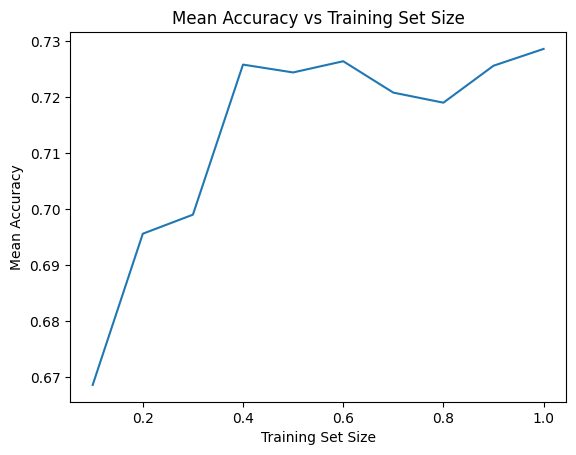

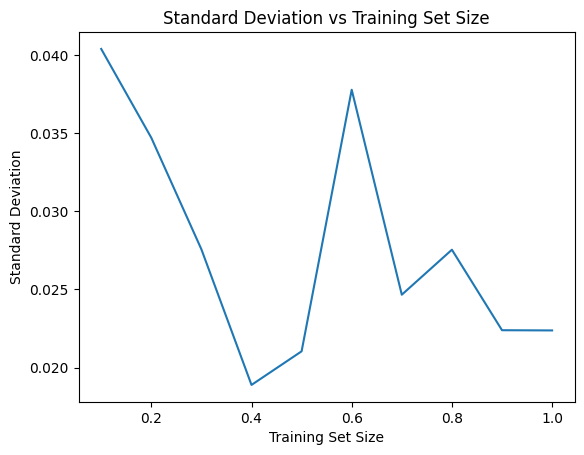

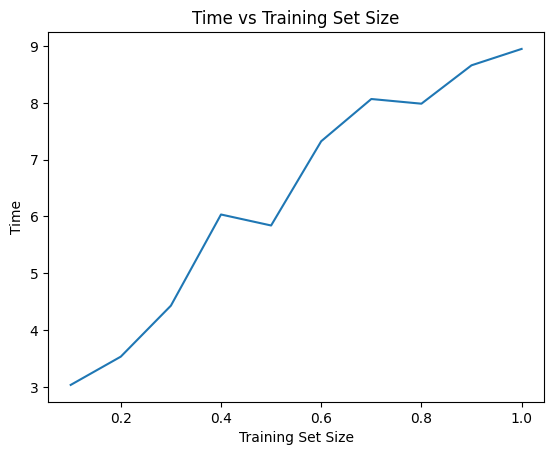

In [25]:
timesOcrArr = []
meanAccOcrArr = []
stdAccOcrArr = []
neuralsOCR = []
for n in training_sets:
    setTimes = []
    setAcc = []
    print(f'Training set size: {n*100:.0f}%')
    for i in range(10):
        print(f'Iteration: {i+1}')
        time, acc, model = OneNNSet(X_train_Ocr, Y_train_Ocr, X_valid_Ocr, Y_valid_Ocr, X_test_Ocr, Y_test_Ocr, 0.01, 128, 10, 50, n ,3)
        # a hidden layer of size 128, learning rate of 0.01, and early stopping after 5 epochs of no improvement we found worked well
        setTimes.append(time)
        setAcc.append(acc)
        neuralsOCR.append(model)
        print("")
    meanTime = np.mean(setTimes)
    meanAcc = np.mean(setAcc)
    stdAcc = np.std(setAcc)
    print(f'Mean Time: {meanTime:.2f} seconds - Mean Accuracy: {meanAcc*100:.2f}% - Standard Deviation: {stdAcc*100:.2f}%')
    timesOcrArr.append(meanTime)
    meanAccOcrArr.append(meanAcc)
    stdAccOcrArr.append(stdAcc)

plt.plot(training_sets, meanAccOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Training Set Size')
plt.show()

plt.plot(training_sets, stdAccOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Training Set Size')
plt.show()

plt.plot(training_sets, timesOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Time')
plt.title('Time vs Training Set Size')
plt.show()


Demo

In [46]:
xDemoTest_OCR, yDemoTest_OCR = process_data(X_test_Ocr, Y_test_Ocr, 1.0)
OCR_test_predictions = neuralsOCR[-1].predict(xDemoTest_OCR)
CorrectPredictionCount = 0
for k in range(len(OCR_test_predictions)):
    if OCR_test_predictions[k] == yDemoTest_OCR[k]:
        CorrectPredictionCount += 1
test_accuracy = CorrectPredictionCount/len(OCR_test_predictions)
print(f'Final OCR Test Accuracy: {test_accuracy*100:.2f}%')

index = 0
demoPrediction = OCR_test_predictions[index]
demoTruth = yDemoTest_OCR[index]
print(f'Demo Prediction: {demoPrediction} - Demo Truth: {demoTruth}')

Final OCR Test Accuracy: 73.00%
Demo Prediction: 1 - Demo Truth: 7


Face Detection

Get training, validating, and testing data and extract features as input to the model

In [27]:
FaceTrainImg = "facedata/facedatatrain"
FaceTrainLabel = "facedata/facedatatrainlabels"

FaceValidImg = "facedata/facedatavalidation"
FaceValidLabel = "facedata/facedatavalidationlabels"

FaceTestImg = "facedata/facedatatest"
FaceTestLabel = "facedata/facedatatestlabels"

X_train_Face, Y_train_Face = face_feature_data(FaceTrainImg, FaceTrainLabel, 2, 2)
X_valid_Face, Y_valid_Face = face_feature_data(FaceValidImg, FaceValidLabel, 2, 2)
X_test_Face, Y_test_Face = face_feature_data(FaceTestImg, FaceTestLabel, 2, 2)

print(X_train_Face.shape)
print(len(Y_train_Face))
print(X_valid_Face.shape)
print(len(Y_valid_Face))
print(X_test_Face.shape)
print(len(Y_test_Face))


(451, 1050)
451
(301, 1050)
301
(150, 1050)
150


Same as for Digit Classification
Train, validate and test on the training set sizes. Perform 10 iterations at each training set. Find the mean and standard deviation of the accuracies at each training set as well as the mean time it took to train at each training set. Store the models from each iteration. Plot mean accuracies, standard deviation of accuracies, and mean elasped times for each training set.

Training set size: 10%
Iteration: 1
Epoch: 1 Train Accuracy: 40.00% Validation Accuracy: 52.16%
Epoch: 2 Train Accuracy: 64.44% Validation Accuracy: 52.16%
Epoch: 3 Train Accuracy: 73.33% Validation Accuracy: 48.17%
Epoch: 4 Train Accuracy: 77.78% Validation Accuracy: 55.15%
Epoch: 5 Train Accuracy: 100.00% Validation Accuracy: 55.15%
Epoch: 6 Train Accuracy: 100.00% Validation Accuracy: 55.15%
Epoch: 7 Train Accuracy: 100.00% Validation Accuracy: 55.15%
Epoch: 8 Train Accuracy: 100.00% Validation Accuracy: 55.15%
Testing Accuracy: 58.67%

Iteration: 2
Epoch: 1 Train Accuracy: 60.00% Validation Accuracy: 54.15%
Epoch: 2 Train Accuracy: 73.33% Validation Accuracy: 58.80%
Epoch: 3 Train Accuracy: 97.78% Validation Accuracy: 56.81%
Epoch: 4 Train Accuracy: 97.78% Validation Accuracy: 56.15%
Epoch: 5 Train Accuracy: 97.78% Validation Accuracy: 56.81%
Epoch: 6 Train Accuracy: 97.78% Validation Accuracy: 57.14%
Testing Accuracy: 60.67%

Iteration: 3
Epoch: 1 Train Accuracy: 46.67% Validation

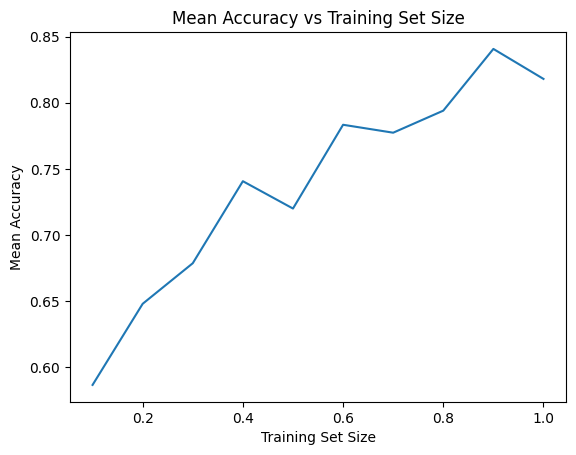

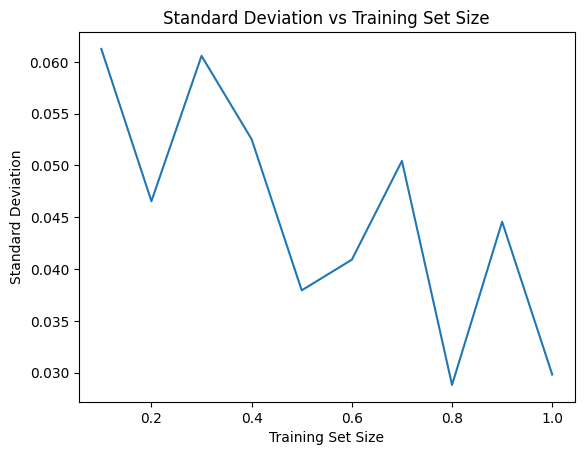

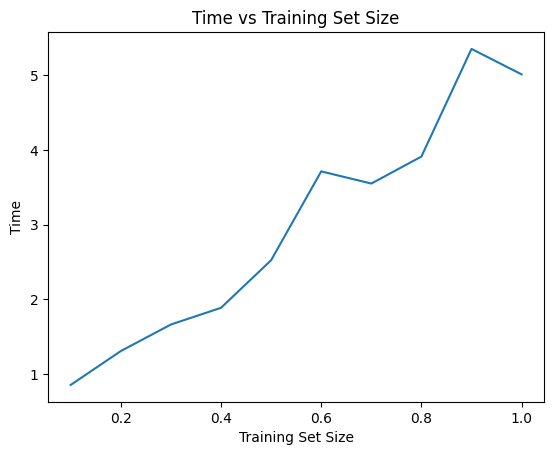

In [28]:
timesFaceArr = []
meanAccFaceArr = []
stdAccFaceArr = []
neuralsFace = []
for n in training_sets:
    setTimes = []
    setAcc = []
    print(f'Training set size: {n*100:.0f}%')
    for i in range(10):
        print(f'Iteration: {i+1}')
        times,acc, model = OneNNSet(X_train_Face, Y_train_Face,X_valid_Face,Y_valid_Face, X_test_Face, Y_test_Face, 0.1, 256, 2, 50, n, 5)
        # a hidden layer of size 256, learning rate of 0.1, and early stopping after 5 epochs of no improvement we found worked well
        setTimes.append(times)
        setAcc.append(acc)
        neuralsFace.append(model)
        print("")
    meanTime = np.mean(setTimes)
    meanAcc = np.mean(setAcc)
    stdAcc = np.std(setAcc)
    print(f'Mean Time: {meanTime:.2f} seconds - Mean Accuracy: {meanAcc*100:.2f}% - Standard Deviation: {stdAcc*100:.2f}%')
    timesFaceArr.append(meanTime)
    meanAccFaceArr.append(meanAcc)
    stdAccFaceArr.append(stdAcc)


plt.plot(training_sets, meanAccFaceArr)
plt.xlabel('Training Set Size')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Training Set Size')
plt.show()

plt.plot(training_sets, stdAccFaceArr)
plt.xlabel('Training Set Size')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Training Set Size')
plt.show()

plt.plot(training_sets, timesFaceArr)
plt.xlabel('Training Set Size')
plt.ylabel('Time')
plt.title('Time vs Training Set Size')
plt.show()



In [58]:
X_demo_test_Face, y_demo_test_Face = process_data(X_test_Face, Y_test_Face, 1.0)
Face_test_predictions = neuralsFace[-1].predict(X_demo_test_Face)
CorrectPredictionCount = 0
for k in range(len(Face_test_predictions)):
    if Face_test_predictions[k] == y_demo_test_Face[k]:
        CorrectPredictionCount += 1
test_accuracy = CorrectPredictionCount/len(Face_test_predictions)
print(f'Final Face Test Accuracy: {test_accuracy*100:.2f}%')

index = 0
demoPrediction = Face_test_predictions[index]
demoTruth = y_demo_test_Face[index]
print(f'Demo Prediction: {demoPrediction} - Demo Truth: {demoTruth}')



Final Face Test Accuracy: 77.33%
Demo Prediction: 0 - Demo Truth: 0
